In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

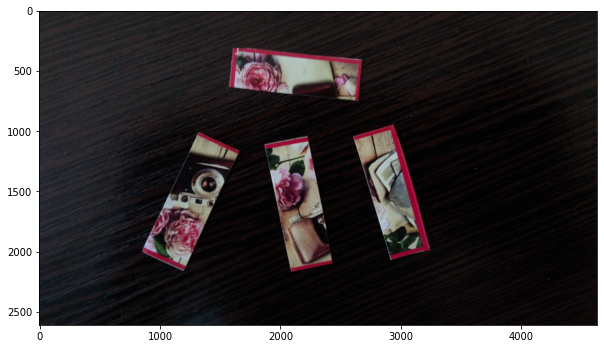

In [2]:
def load_img(path, *args):
    return cv2.imread(str(path), *args)

def plot_one_img(img, *, bgr=False, cmap=None):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    _img = img[..., ::-1] if bgr else img
    ax.imshow(_img, cmap=cmap)

data_dir = Path('./Images')
input_img = 'puzzle_4.jpg'
origin = load_img(data_dir / input_img)
plot_one_img(origin, bgr=True)

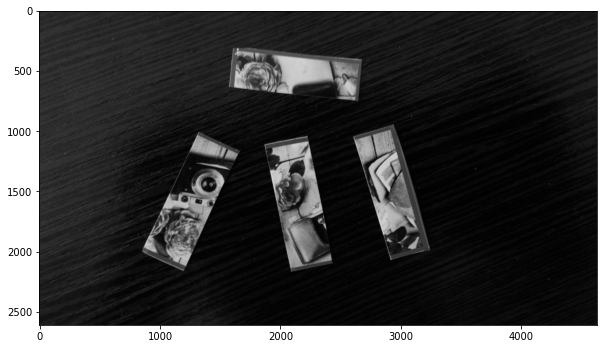

In [3]:
gray = cv2.cvtColor(origin, cv2.COLOR_BGR2GRAY)
plot_one_img(gray, cmap='gray')

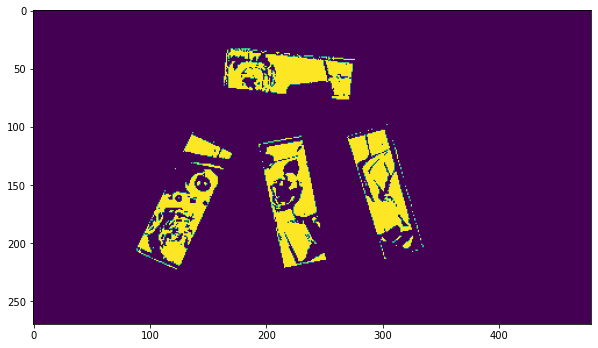

In [4]:
_gray = cv2.resize(gray, (16*30, 9*30))
_, mask = cv2.threshold(_gray, 127, 255, cv2.THRESH_OTSU)
plot_one_img(mask)

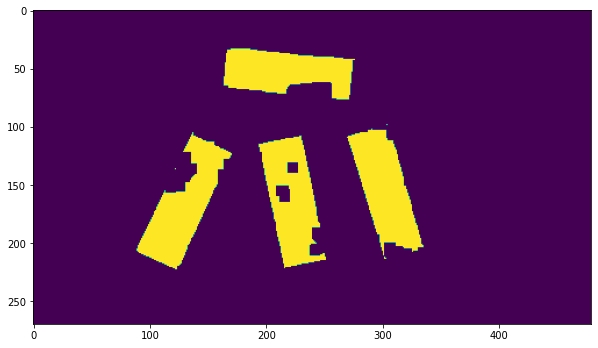

In [5]:
morph_mask = cv2.morphologyEx(mask,
                              cv2.MORPH_CLOSE,
                              np.ones([3, 3]),
                              iterations=4)
plot_one_img(morph_mask)

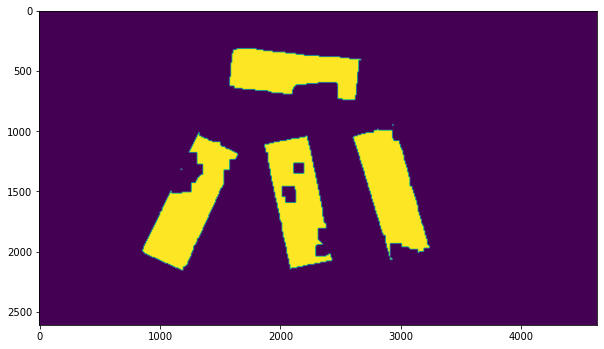

In [6]:
scaled_mask = cv2.resize(morph_mask,
                         origin.shape[:2][::-1])
plot_one_img(scaled_mask)

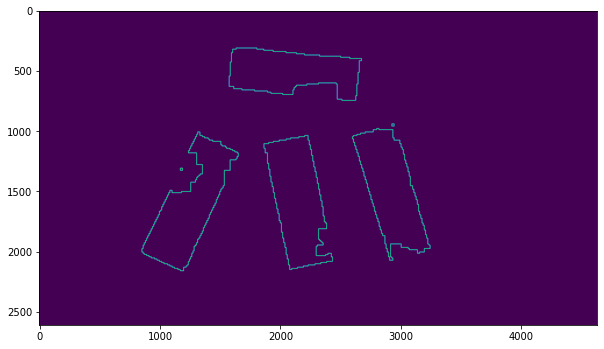

In [7]:
cts, _ = cv2.findContours(scaled_mask,
                          cv2.RETR_EXTERNAL,
                          cv2.CHAIN_APPROX_SIMPLE)
canvas = np.zeros_like(scaled_mask)
canvas = cv2.drawContours(canvas, cts, -1, (255,), 3)
plot_one_img(canvas)

In [8]:
min_vertex = 100
rrects = []

for c in cts:
    e = cv2.minAreaRect(c)
    rrects.append((e, c))
    
while len(rrects) > 4:
    min_elem = sorted(rrects, key=lambda x: cv2.contourArea(x[1]))[0]
    print(f'Square: {cv2.contourArea(min_elem[1])}')
    del_idx = rrects.index(min_elem)
    del rrects[del_idx]
    
assert len(rrects) == 4
rrects = [x for x, y in rrects]

Square: 324.0
Square: 326.5


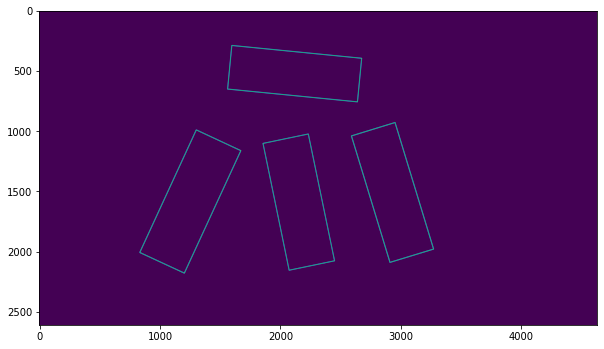

In [9]:
canvas = np.zeros_like(scaled_mask)

for r in rrects:
    box = cv2.boxPoints(r)
    box = np.int0(box)
    canvas = cv2.drawContours(canvas, [box], 0, (255,), 3)
plot_one_img(canvas)

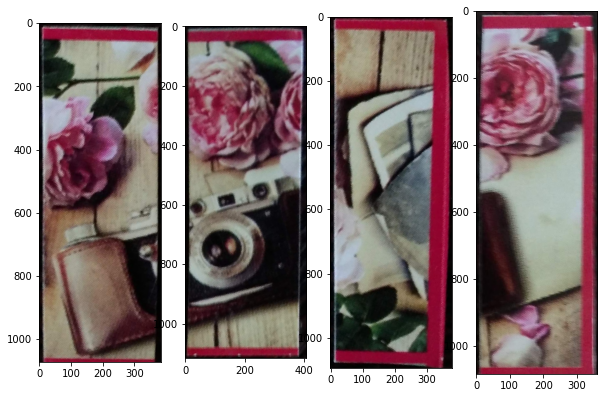

In [10]:
def inside_rect(rect, num_cols, num_rows):
    rect_center = rect[0]
    rect_center_x = rect_center[0]
    rect_center_y = rect_center[1]

    rect_width, rect_height = rect[1]

    rect_angle = rect[2]

    if (rect_center_x < 0) or (rect_center_x > num_cols):
        return False
    if (rect_center_y < 0) or (rect_center_y > num_rows):
        return False

    box = cv2.boxPoints(rect)

    x_max = int(np.max(box[:,0]))
    x_min = int(np.min(box[:,0]))
    y_max = int(np.max(box[:,1]))
    y_min = int(np.min(box[:,1]))

    if (x_max <= num_cols) and (x_min >= 0) and (y_max <= num_rows) and (y_min >= 0):
        return True
    else:
        return False


def rect_bbx(rect):
    box = cv2.boxPoints(rect)

    x_max = int(np.max(box[:,0]))
    x_min = int(np.min(box[:,0]))
    y_max = int(np.max(box[:,1]))
    y_min = int(np.min(box[:,1]))
    center = (int((x_min + x_max) // 2), int((y_min + y_max) // 2))
    width = int(x_max - x_min)
    height = int(y_max - y_min)
    angle = 0
    return (center, (width, height), angle)

def image_rotate_without_crop(mat, angle):
    # https://stackoverflow.com/questions/22041699/rotate-an-image-without-cropping-in-opencv-in-c
    # angle in degrees

    height, width = mat.shape[:2]
    image_center = (width/2, height/2)

    rotation_mat = cv2.getRotationMatrix2D(image_center, angle, 1)

    abs_cos = abs(rotation_mat[0,0])
    abs_sin = abs(rotation_mat[0,1])

    bound_w = int(height * abs_sin + width * abs_cos)
    bound_h = int(height * abs_cos + width * abs_sin)

    rotation_mat[0, 2] += bound_w/2 - image_center[0]
    rotation_mat[1, 2] += bound_h/2 - image_center[1]

    rotated_mat = cv2.warpAffine(mat, rotation_mat, (bound_w, bound_h))

    return rotated_mat

def crop_rectangle(image, rect):
    # rect has to be upright

    num_rows = image.shape[0]
    num_cols = image.shape[1]

    if not inside_rect(rect = rect, num_cols = num_cols, num_rows = num_rows):
        print("Proposed rectangle is not fully in the image.")
        return None

    rect_center = rect[0]
    rect_center_x = rect_center[0]
    rect_center_y = rect_center[1]
    rect_width = rect[1][0]
    rect_height = rect[1][1]


    return image[rect_center_y-rect_height//2:rect_center_y+rect_height-rect_height//2, rect_center_x-rect_width//2:rect_center_x+rect_width-rect_width//2]

def crop_rotated_rectangle(image, rect):
    num_rows = image.shape[0]
    num_cols = image.shape[1]

    if not inside_rect(rect = rect, num_cols = num_cols, num_rows = num_rows):
        print("Proposed rectangle is not fully in the image.")
        return None

    rotated_angle = rect[2]

    rect_bbx_upright = rect_bbx(rect = rect)
    rect_bbx_upright_image = crop_rectangle(image = image, rect = rect_bbx_upright)

    rotated_rect_bbx_upright_image = image_rotate_without_crop(mat = rect_bbx_upright_image, angle = rotated_angle)

    rect_width = int(rect[1][0])
    rect_height = int(rect[1][1])

    crop_center = (rotated_rect_bbx_upright_image.shape[1]//2, rotated_rect_bbx_upright_image.shape[0]//2)

    return rotated_rect_bbx_upright_image[crop_center[1]-rect_height//2 : crop_center[1]+(rect_height-rect_height//2),
                                          crop_center[0]-rect_width//2 : crop_center[0]+(rect_width-rect_width//2)]

def plot_4_parts(p, *, bgr=False, cmap=None):
    fig, ax = plt.subplots(ncols=len(p), nrows=1, figsize=(10, 10))
    for idx, i in enumerate(p):
        i = i[..., ::-1] if bgr else i
        ax[idx].imshow(i, cmap=cmap)
    
cropped_parts = [crop_rotated_rectangle(origin, x) for x in rrects]
for idx, p in enumerate(cropped_parts):
    if p.shape[1] > p.shape[0]:
        cropped_parts[idx] = cv2.rotate(p, cv2.ROTATE_90_CLOCKWISE)
        
plot_4_parts(cropped_parts, bgr=True)

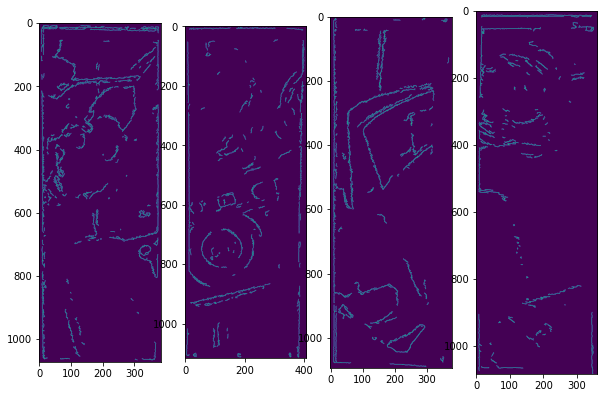

In [11]:
p_edges = []
for p in cropped_parts:
    p = cv2.cvtColor(p, cv2.COLOR_BGR2GRAY)
    e = cv2.Canny(p, 127, 240)
    p_edges.append(e)
    
plot_4_parts(p_edges)

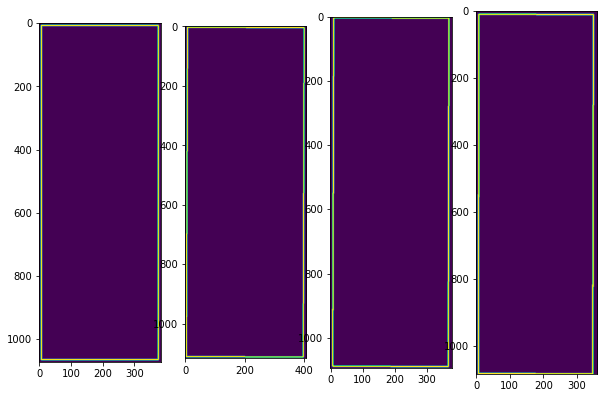

In [12]:
e_rrects = []
for e in p_edges:
    a = np.where(e > 0)
    pts = np.stack(a[::-1]).astype(np.int32).T
    pts = np.expand_dims(pts, axis=1)
    r = cv2.minAreaRect(pts)
    e_rrects.append(r)
    
    
e_r_canvas = []
for r, pe in zip(e_rrects, p_edges):
    canvas = np.zeros_like(pe)
    box = cv2.boxPoints(r)
    box = np.int0(box)
    canvas = cv2.drawContours(canvas, [box], 0, (255,), 3)
    e_r_canvas.append(canvas)
    
plot_4_parts(e_r_canvas)

((191.49996948242188, 535.9998779296875), (368.99993896484375, 1057.999755859375), 0.0)
((201.60606384277344, 560.4696655273438), (1105.171630859375, 390.1807861328125), -89.8313217163086)
((188.6074981689453, 547.8048706054688), (1083.992431640625, 357.2211608886719), -89.89230346679688)
((177.73818969726562, 545.8936767578125), (1071.86376953125, 339.5070495605469), -89.94068908691406)


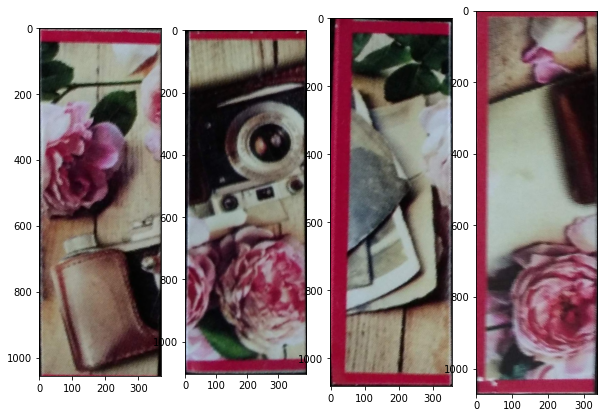

In [13]:
tunned_parts = []
for p, pr in zip(cropped_parts, e_rrects):
    print(pr)
    tuned_p = crop_rotated_rectangle(p, pr)
    tuned_p = tuned_p if tuned_p is not None else p
    if tuned_p.shape[1] > tuned_p.shape[0]:
        tuned_p = cv2.rotate(tuned_p, cv2.ROTATE_90_CLOCKWISE)
        
    tunned_parts.append(tuned_p)

plot_4_parts(tunned_parts, bgr=True)

25.619001 False A_l, B_r


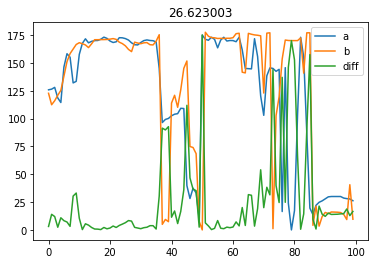

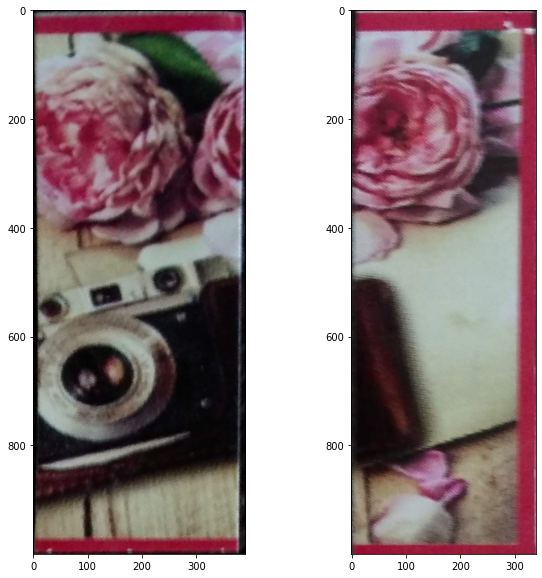

46.972 False A_l, B_r


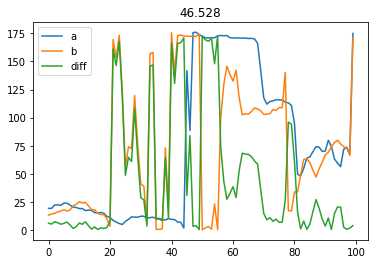

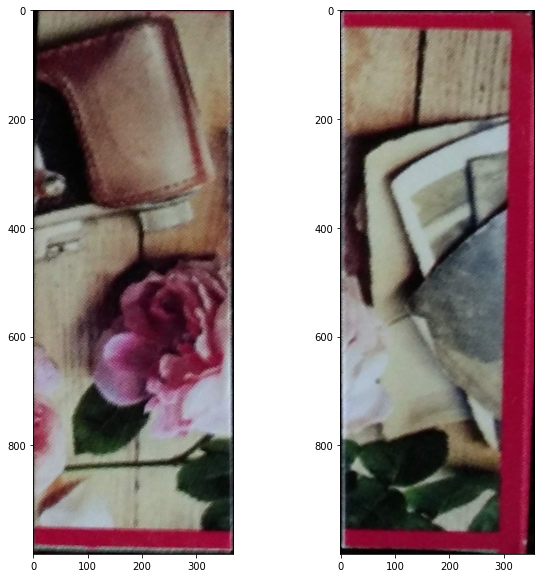

49.025 False A_l, B_l


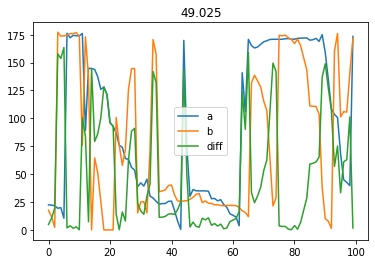

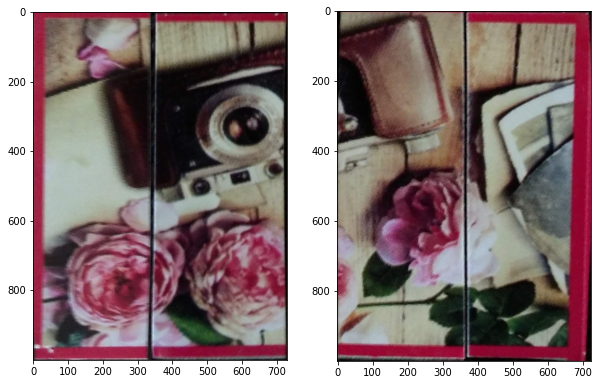

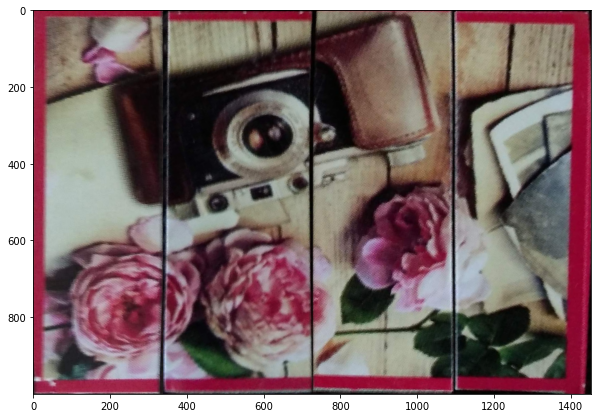

In [14]:
from scipy.spatial.distance import cosine
h_size = 100

def calc_part_hist(p, *, vis=False, pos_code='l'):
    mask = np.zeros(p.shape[:2], dtype=np.uint8)
    w = 10
    pad = 30
    pos = pad if pos_code == 'l' else p.shape[1]-pad-w
    h_pad = 40
    hist_data = p[: ,pos:pos+w]
    hist_data = hist_data[h_pad:, ...]
    hist_data = hist_data[:hist_data.shape[0]-h_pad, ...]
    hist_data = cv2.resize(hist_data, (w, h_size))
    hist_data = cv2.cvtColor(hist_data, cv2.COLOR_BGR2HSV)[:, :, 0]


    if vis:
        plot_one_img(hist_data)
    hist = np.mean(hist_data, axis=1)
    if vis:
        return hist, hist_data
    return hist


def match(a, b, *, vis=False, vis_all=False):
    a_hist = calc_part_hist(a, pos_code='r')
    b_hist = calc_part_hist(b, pos_code='l')
    a_hist = a_hist.astype(np.float32)
    b_hist = b_hist.astype(np.float32)
    diff = np.abs(a_hist-b_hist)
    score = np.mean(diff)
    
    vis = vis_all
    if vis:
        plt.plot(range(h_size), a_hist, label='a')
        plt.plot(range(h_size), b_hist, label='b')
        plt.plot(range(h_size), diff, label='diff')
        plt.legend()
        plt.title(score)
        plt.show()
        plot_4_parts([a, b], bgr=True)
        plt.show()
    
    return score
    

import copy

parts = copy.deepcopy(tunned_parts)
while len(parts) > 1:

    best_pair = None
    best_score = np.inf
    best_pair_idx = (None, None)
    match_type = (None, None)
    rot = False

    for idx, i in enumerate(parts):
        for jdx, j in enumerate(parts):
            if idx == jdx:
                continue

            left = i
            right = j

            s = match(left, right, vis=True)
            if s < best_score:
                rot = False
                best_score = s
                best_pair = (left, right)
                best_pair_idx = (idx, jdx)
                match_type = ('A_r, B_l')

            left = cv2.rotate(left, cv2.ROTATE_180)
            s = match(left, right, vis=True)
            if s < best_score:
                rot = False
                best_score = s
                best_pair = (left, right)
                best_pair_idx = (idx, jdx)
                match_type = ('A_l, B_l')
                
            right = cv2.rotate(right, cv2.ROTATE_180)
            s = match(left, right, vis=True)
            if s < best_score:
                rot = False
                best_score = s
                best_pair = (left, right)
                best_pair_idx = (idx, jdx)
                match_type = ('A_l, B_r')
                
            left = cv2.rotate(left, cv2.ROTATE_180)
            s = match(left, right, vis=True)
            if s < best_score:
                rot = False
                best_score = s
                best_pair = (left, right)
                best_pair_idx = (idx, jdx)
                match_type = ('A_r, B_r')
            
    p_size = 1000
    left, right = best_pair
    
    left = cv2.resize(left, (left.shape[1], p_size))
    right = cv2.resize(right, (right.shape[1], p_size))
    if rot:
        left, right = right, left

    res = np.concatenate([left, right], axis=1)

    del parts[np.max(best_pair_idx)]
    del parts[np.min(best_pair_idx)]
    parts.append(res)
    
    print(best_score, rot, match_type)
    match(left, right, vis_all=True)
    
    
plot_one_img(res, bgr=True)

In [15]:
cv2.imwrite(str(data_dir / ('result_' + str(input_img))), res)
cv2.imwrite(str(data_dir / ('result_rotate' + str(input_img))), cv2.rotate(res, cv2.ROTATE_180))

True

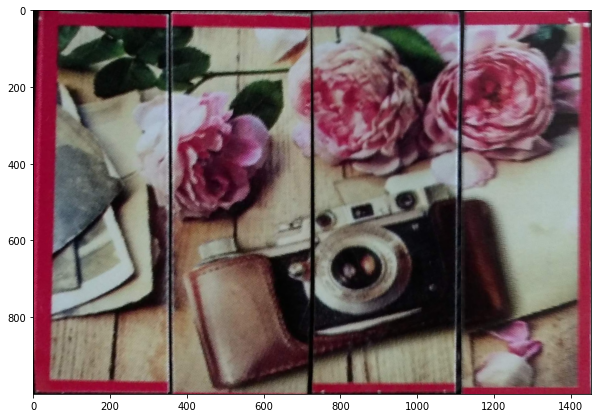

In [16]:
plot_one_img(cv2.rotate(res, cv2.ROTATE_180), bgr=True)